# <b>Regression with a Tabular California Housing Dataset</b>

In [4]:
# !pip install catboost
# !pip install haversine
# !pip install umap-learn
# !pip install reverse_geocoder

## 1. Import Libraries

In [5]:
import os
import random
import gc

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from umap import UMAP

from haversine import haversine
import reverse_geocoder as rg
from shapely.geometry import LineString, Point

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

import warnings
warnings.filterwarnings('ignore')

### 1-1. Fixed Seed

In [6]:
def seed_everything(seed: int=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

## 2. Load Data
`train.csv`: 학습 데이터, 타겟: MedHouseVal<br>
`test.csv`: 테스트 데이터 <br>

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### 2-1. 데이터 설명

In [8]:
def data_describe(df, title):
    print(f'====================== {title} Data Describe ======================')
    print(f'Row: {df.shape[0]}, Column: {df.shape[1]}')
    columns = df.columns
    data_type = []

    for col in columns:
        data_type.append(df[col].dtype)

    n_uniq = df.nunique()
    n_miss = df.isna().sum()

    names = list(zip(columns, data_type, n_uniq, n_miss))
    variable_desc = pd.DataFrame(names, columns=['Column', 'Dtype', 'Unique levels', 'Missing Count'])
    print(variable_desc)

In [9]:
data_describe(train, 'Train')

====================== Train Data Describe ======================
Row: 37137, Column: 10
        Column    Dtype  Unique levels  Missing Count
0           id    int64          37137              0
1       MedInc  float64          12310              0
2     HouseAge  float64             51              0
3     AveRooms  float64          22069              0
4    AveBedrms  float64          14066              0
5   Population  float64           3694              0
6     AveOccup  float64          21078              0
7     Latitude  float64            791              0
8    Longitude  float64            755              0
9  MedHouseVal  float64           3723              0


In [10]:
train.head()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980
1,1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946
2,2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576
3,3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336
4,4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500


In [11]:
data_describe(test, 'Test')

====================== Test Data Describe ======================
Row: 24759, Column: 9
       Column    Dtype  Unique levels  Missing Count
0          id    int64          24759              0
1      MedInc  float64          10239              0
2    HouseAge  float64             51              0
3    AveRooms  float64          16763              0
4   AveBedrms  float64          11147              0
5  Population  float64           3454              0
6    AveOccup  float64          15938              0
7    Latitude  float64            745              0
8   Longitude  float64            736              0


In [12]:
test.head()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,37137,1.7062,35.0,4.966368,1.096539,1318.0,2.844411,39.75,-121.85
1,37138,1.3882,22.0,4.187035,1.098229,2296.0,3.180218,33.95,-118.29
2,37139,7.7197,21.0,7.129436,0.959276,1535.0,2.888889,33.61,-117.81
3,37140,4.6806,49.0,4.769697,1.048485,707.0,1.743590,34.17,-118.34
4,37141,3.1284,25.0,3.765306,1.081633,4716.0,2.003827,34.17,-118.29


## 3. EDA

### 3-1. Feature Distribution

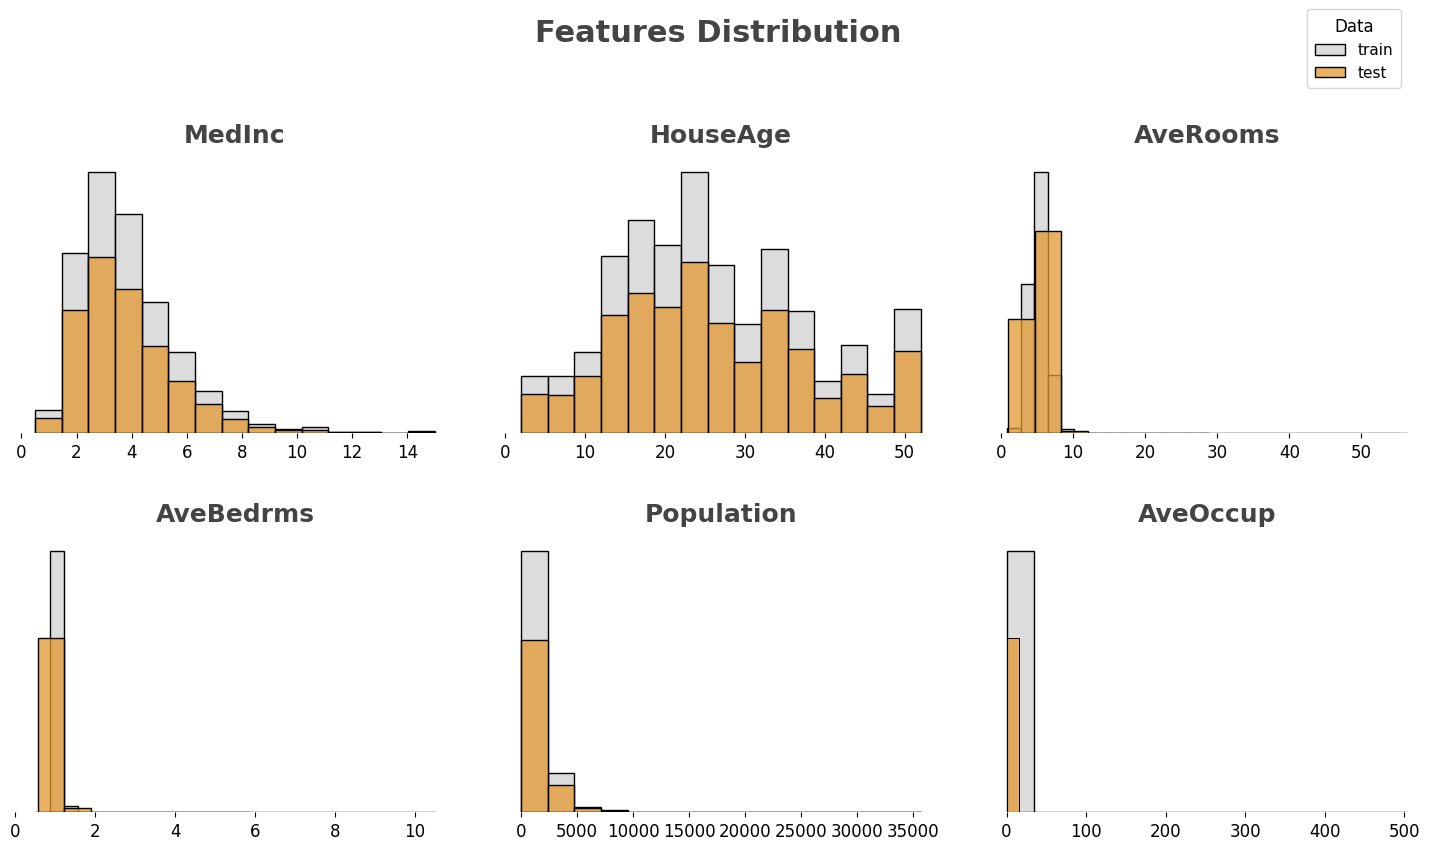

In [13]:
fig = plt.figure(figsize = (15, 8))

for i, col in enumerate(train.columns[1:7]):
    plt.subplot(2, 3, i+1)
    plt.title(col, size=18, y=1.03, fontweight='bold', color='#444444')
    a = sns.histplot(train[col], color='#d1d1d1', bins=15, label='train')
    sns.histplot(test[col], color='#e29930', bins=15, label='test')
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(size=12)
    plt.yticks([])
    for s in ['right', 'top', 'left', 'bottom']:
        a.spines[s].set_visible(False)

fig.tight_layout(pad=3)
fig.legend(['train', 'test'], bbox_to_anchor=(0.96, 1.1),
           ncol=1, borderpad=0.5, frameon=True, fontsize=11,
           title='Data', title_fontsize=12)
plt.figtext(0.5, 1.05, 'Features Distribution',
            fontweight='bold', size=22, color='#444444', ha='center')
plt.show()

### 3-2. Target Distribution

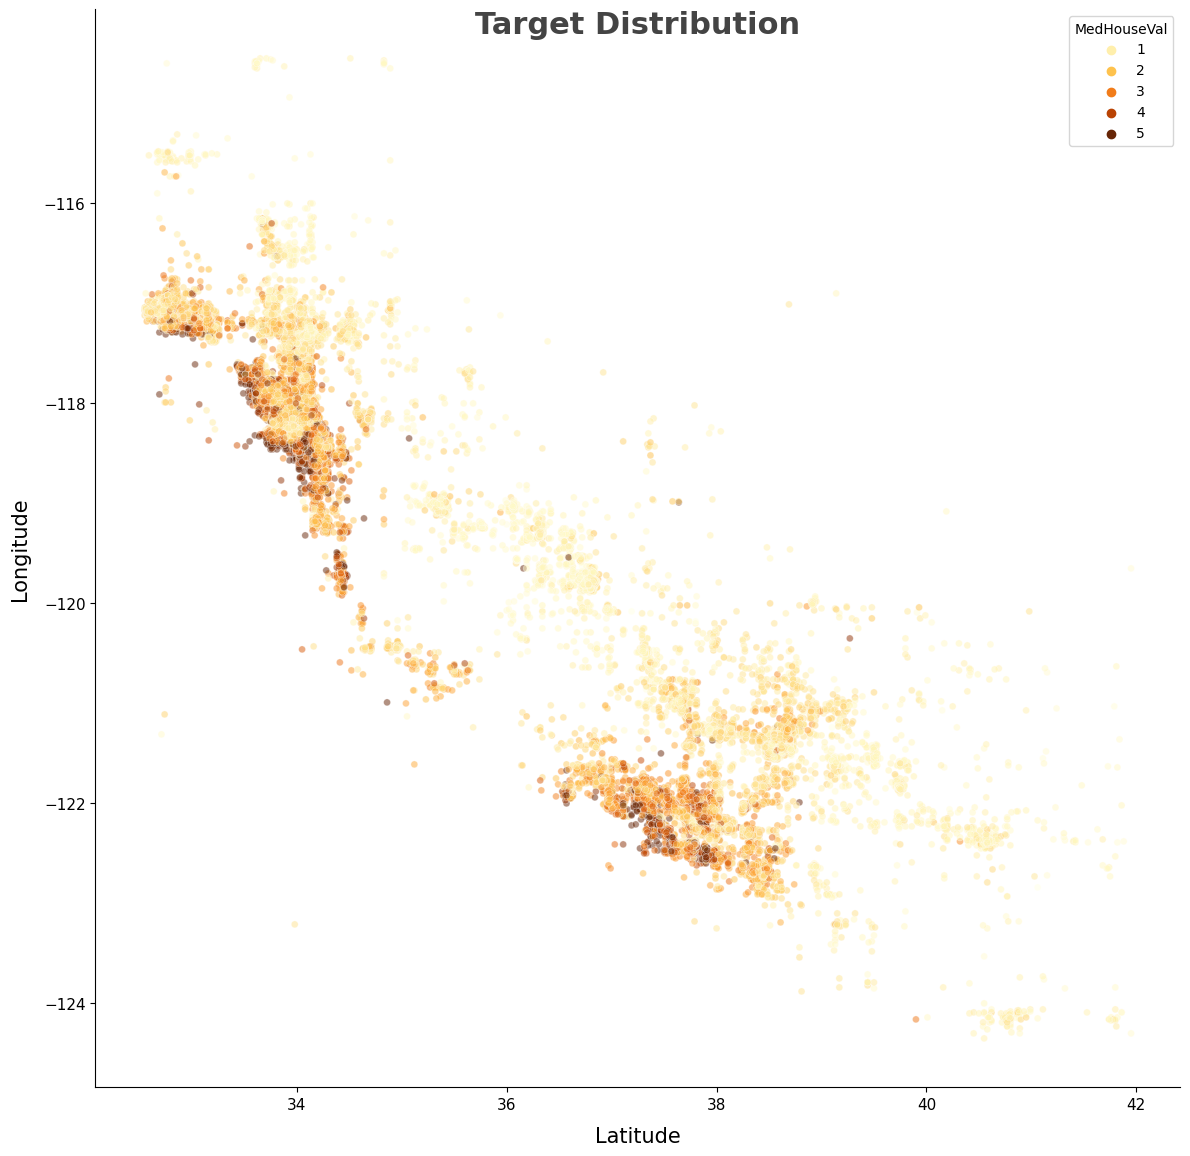

In [14]:
plt.figure(figsize=(14, 14))
plt.title('Target Distribution', size=22, y=0.97, fontweight='bold', color='#444444')
a = sns.scatterplot(data=train, x='Latitude', y='Longitude', hue='MedHouseVal',
                    palette=sns.color_palette('YlOrBr', as_cmap=True), s=25, alpha=0.5)
plt.xticks(size=11)
plt.yticks(size=11)
plt.xlabel('Latitude', labelpad=10, fontsize=15)
plt.ylabel('Longitude', labelpad=10, fontsize=15)

for j in ['right', 'top']:
    a.spines[j].set_visible(False)

plt.show()

## 4. Preprocessing

In [15]:
# Generated data
train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

train.loc[33228, ['Latitude', 'Longitude']] = [32.74, -117]
train.loc[34363, ['Latitude', 'Longitude']] = [32.71, -117]
train.loc[20991, ['Latitude', 'Longitude']] = [34.2, -119]

df = pd.concat([train, test], axis=0, ignore_index=True)
coordinates = df[['Latitude', 'Longitude']].values

In [16]:
# Encoding trick
emb_size = 20
precision = 1e6

latlon = np.expand_dims(coordinates, axis=-1)

m = np.exp(np.log(precision) / emb_size)
angle_freq = m ** np.arange(emb_size)
angle_freq = angle_freq.reshape(1, 1, emb_size)

latlon = latlon * angle_freq
latlon[..., 0::2] = np.cos(latlon[..., 0::2])
latlon[..., 1::2] = np.sin(latlon[..., 1::2])
latlon = latlon.reshape(-1, 2 * emb_size)

df['exp_latlon1'] = [lat[0] for lat in latlon]
df['exp_latlon2'] = [lat[1] for lat in latlon]

In [17]:
# Clustering
clustering = KMeans(n_clusters=20,
                    max_iter=1111,
                    random_state=42).fit(coordinates)

cluster_centers = {i: tuple(centroid) for i, centroid in enumerate(clustering.cluster_centers_)}
def cluster_features(df):
    for i, cc in enumerate(cluster_centers.values()):
        df[f'cluster_{i}'] = df.apply(lambda x: haversine((x['Latitude'], x['Longitude']), cc, unit='ft'), axis=1)
    return df
df = cluster_features(df)

In [18]:
# Coordinates with PCA and UMAP
pca = PCA().fit(coordinates)
df['pca_lat'] = pca.transform(coordinates)[:,0]
df['pca_lon'] = pca.transform(coordinates)[:,1]

umap = UMAP(n_components=2,
            n_neighbors=50,
            random_state=42).fit(coordinates)
df['umap_lat'] = umap.transform(coordinates)[:,0]
df['umap_lon'] = umap.transform(coordinates)[:,1]

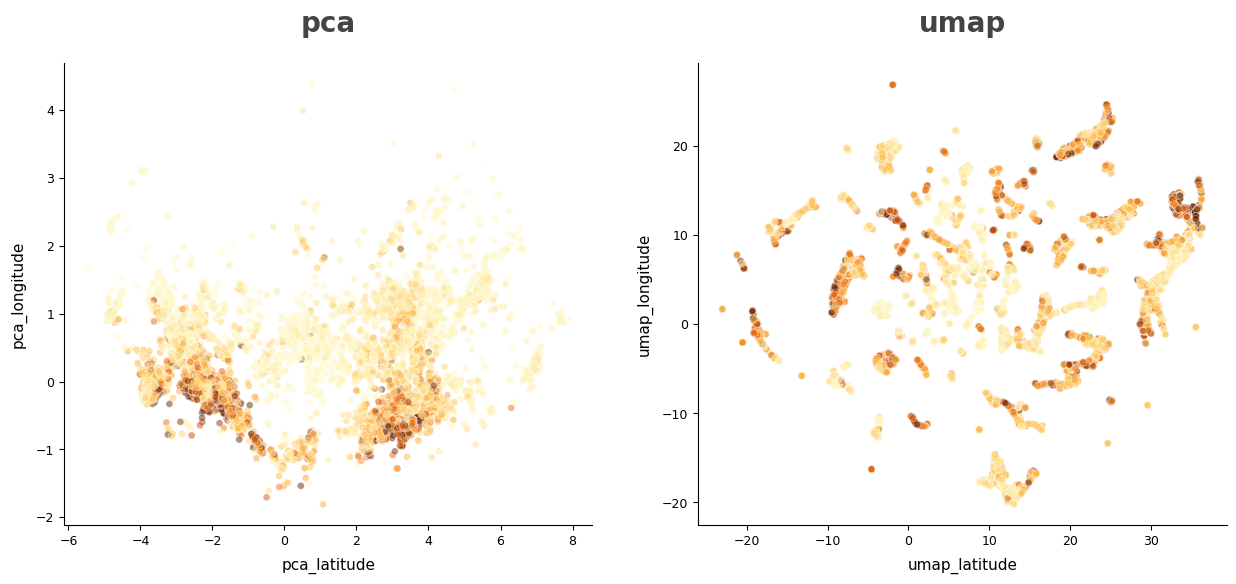

In [19]:
train = df.iloc[:-len(test),:]

fig = plt.figure(figsize=(15, 6))
for i, col in enumerate(['pca', 'umap']):
    plt.subplot(1,2,i+1)
    plt.title(col, size=20, y=1.05, fontweight='bold', color='#444444')
    a = sns.scatterplot(data=train, x=f'{col}_lat', y=f'{col}_lon', hue='MedHouseVal',
                        palette=sns.color_palette('YlOrBr', as_cmap=True), s=25, alpha=0.5)
    plt.xticks(size=9)
    plt.yticks(size=9)
    plt.xlabel(f'{col}_latitude', labelpad=7, fontsize=11)
    plt.ylabel(f'{col}_longitude', labelpad=7, fontsize=11)

    for j in ['right', 'top']:
        a.spines[j].set_visible(False)
    a.get_legend().remove()

plt.show()

In [20]:
# Cartesian coordinates rotation
df['rot_15_x'] = (np.cos(np.radians(15)) * df['Longitude']) + \
                  (np.sin(np.radians(15)) * df['Latitude'])

df['rot_15_y'] = (np.cos(np.radians(15)) * df['Latitude']) + \
                  (np.sin(np.radians(15)) * df['Longitude'])

df['rot_30_x'] = (np.cos(np.radians(30)) * df['Longitude']) + \
                  (np.sin(np.radians(30)) * df['Latitude'])

df['rot_30_y'] = (np.cos(np.radians(30)) * df['Latitude']) + \
                  (np.sin(np.radians(30)) * df['Longitude'])

df['rot_45_x'] = (np.cos(np.radians(44)) * df['Longitude']) + \
                  (np.sin(np.radians(45)) * df['Latitude'])

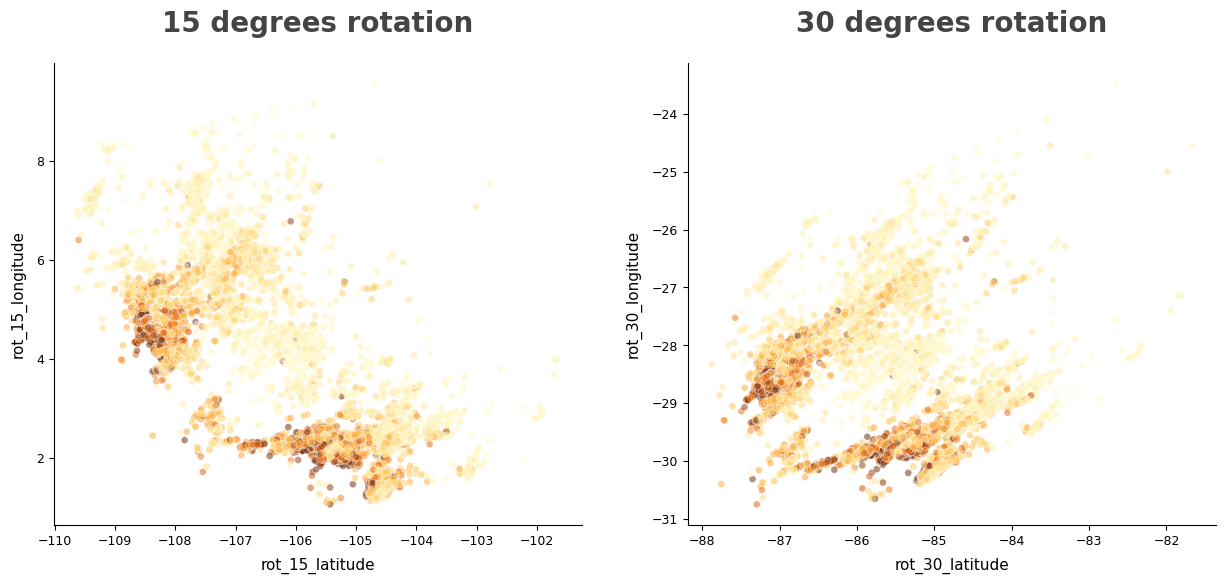

In [21]:
train = df.iloc[:-len(test),:]

fig = plt.figure(figsize=(15, 6))
for i, col in enumerate(['15', '30']):
    plt.subplot(1,2,i+1)
    plt.title(f'{col} degrees rotation', size=20, y=1.05, fontweight='bold', color='#444444')
    a = sns.scatterplot(data=train, x=f'rot_{col}_x', y=f'rot_{col}_y', hue='MedHouseVal',
                        palette=sns.color_palette('YlOrBr', as_cmap=True), s=25, alpha=0.5)
    plt.xticks(size=9)
    plt.yticks(size=9)
    plt.xlabel(f'rot_{col}_latitude', labelpad=7, fontsize=11)
    plt.ylabel(f'rot_{col}_longitude', labelpad=7, fontsize=11)

    for j in ['right', 'top']:
        a.spines[j].set_visible(False)
    a.get_legend().remove()

plt.show()

In [22]:
# Location of coordinates
coordinates = list(zip(df['Latitude'], df['Longitude']))
results = rg.search(coordinates)
df['place'] = [x['admin2'] for x in results]

places = ['Los Angeles County', 'Orange County', 'Kern County',
          'Alameda County', 'San Francisco County', 'Ventura County',
          'Santa Clara County', 'Fresno County', 'Santa Barbara County',
          'Contra Costa County', 'Yolo County', 'Monterey County',
          'Riverside County', 'Napa County']

def replace(x):
    if x in places:
        return x
    else:
        return 'Other'

df['place'] = df['place'].apply(lambda x: replace(x))
le = LabelEncoder()
df['place'] = le.fit_transform(df['place'])

Loading formatted geocoded file...


In [23]:
# Distance to cities and coast points
SC = (38.576931, -121.494949)
SF = (37.780080, -122.420160)
SJ = (37.334789, -121.888138)
LA = (34.052235, -118.243683)
SD = (32.715759, -117.163818)

df['dist_SC'] = df.apply(lambda x: haversine((x['Latitude'], x['Longitude']), SC, unit='ft'), axis=1)
df['dist_SF'] = df.apply(lambda x: haversine((x['Latitude'], x['Longitude']), SF, unit='ft'), axis=1)
df['dist_SJ'] = df.apply(lambda x: haversine((x['Latitude'], x['Longitude']), SJ, unit='ft'), axis=1)
df['dist_LA'] = df.apply(lambda x: haversine((x['Latitude'], x['Longitude']), LA, unit='ft'), axis=1)
df['dist_SD'] = df.apply(lambda x: haversine((x['Latitude'], x['Longitude']), SD, unit='ft'), axis=1)
df['dist_nearest_city'] = df[['dist_SC', 'dist_SF', 'dist_SJ',
                              'dist_LA', 'dist_SD']].min(axis=1)

In [24]:
coast_points = LineString([(32.664, -117.161), (33.206, -117.383),
                           (33.777, -118.202), (34.463, -120.014),
                           (35.427, -120.881), (35.928, -121.489),
                           (36.982, -122.028), (37.611, -122.491),
                           (38.355, -123.060), (39.792, -123.821),
                           (40.799, -124.188), (41.755, -124.197)])

df['dist_to_coast'] = df.apply(lambda x: Point(x['Latitude'], x['Longitude']).distance(coast_points), axis=1)

In [25]:
train = df.iloc[:-len(test),:]
test = df.iloc[-len(test):,:].drop('MedHouseVal', axis=1).reset_index(drop=True)

X = train.drop('MedHouseVal', axis=1)
y = train['MedHouseVal']

## 5. Train Model
- 평가지표: `Root Mean Squared Error (RMSE)`

In [26]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def f_importance_plot(f_imp):
    fig = plt.figure(figsize = (15, 0.35*len(f_imp)))
    plt.title('Feature importances', size=25, y=1.05, fontweight='bold', color='#444444')
    a = sns.barplot(data=f_imp, x='avg_imp', y='feature',
                    palette='Blues_d', linestyle="-",
                    linewidth=1, edgecolor="black")
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('')
    plt.yticks(size=11, color='#444444')

    for j in ['right', 'top', 'bottom']:
        a.spines[j].set_visible(False)
    for j in ['left']:
        a.spines[j].set_linewidth(0.5)
    plt.show()

In [27]:
FOLDS = 5

### 5-1. Train LightGBM Model

In [28]:
lgb_params = {
    'max_depth': 9,
    'learning_rate': 0.01,
    'min_data_in_leaf': 36,
    'num_leaves': 100,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.89,
    'bagging_freq': 5,
    'lambda_l2': 28,
    'seed': 42,
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'device': 'cpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'n_jobs': -1,
    'metric': 'rmse',
    'verbose': -1
}


--- FOLD 1 ---
[1000]	train's rmse: 0.46482	val's rmse: 0.580633
[2000]	train's rmse: 0.422076	val's rmse: 0.579402
--- RMSE: 0.579237 | best iteration: 1772 ---

--- FOLD 2 ---
[1000]	train's rmse: 0.471721	val's rmse: 0.548517
[2000]	train's rmse: 0.42691	val's rmse: 0.548661
--- RMSE: 0.548137 | best iteration: 1657 ---

--- FOLD 3 ---
[1000]	train's rmse: 0.469931	val's rmse: 0.559962
--- RMSE: 0.559875 | best iteration: 920 ---

--- FOLD 4 ---
[1000]	train's rmse: 0.472068	val's rmse: 0.545003
[2000]	train's rmse: 0.42933	val's rmse: 0.545989
--- RMSE: 0.54482 | best iteration: 1213 ---

--- FOLD 5 ---
[1000]	train's rmse: 0.471976	val's rmse: 0.546383
[2000]	train's rmse: 0.429147	val's rmse: 0.547221
--- RMSE: 0.545902 | best iteration: 1227 ---
Mean RMSE: 0.555594


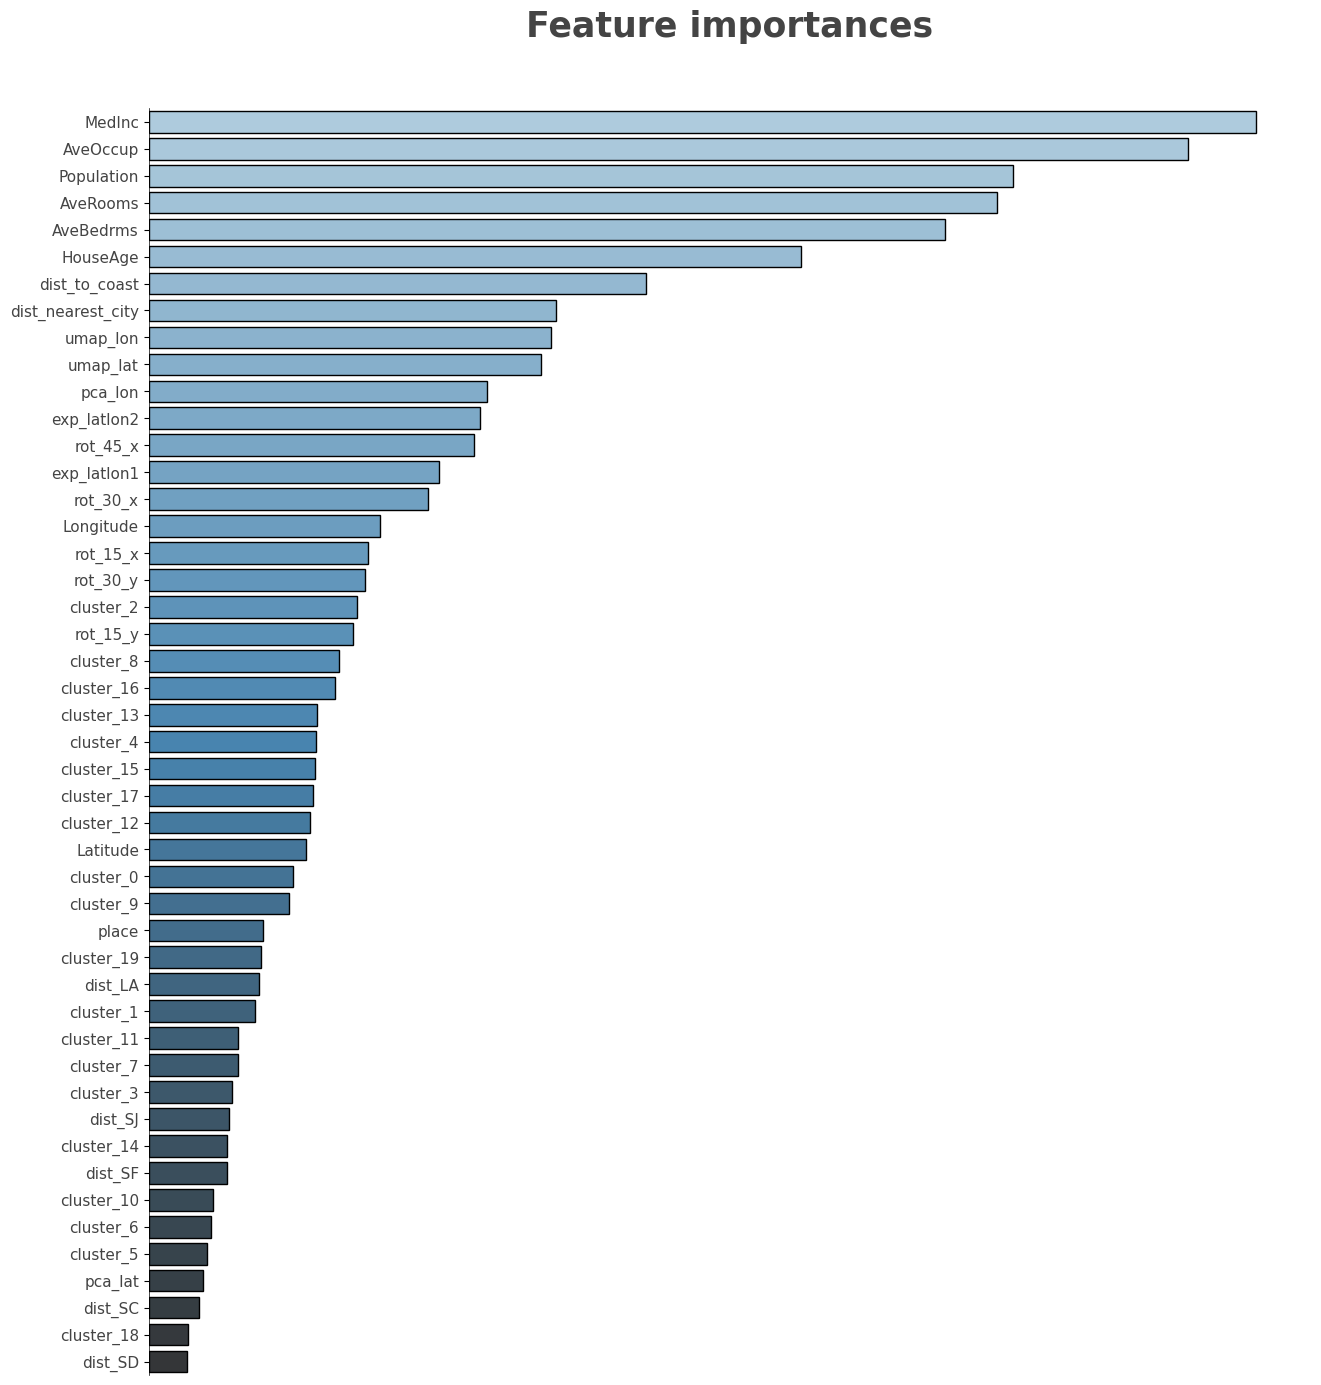

In [29]:
f_imp = pd.DataFrame({'feature': X.columns})
predictions, scores = np.zeros(len(test)), []

k = KFold(n_splits=FOLDS, random_state=42, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(k.split(X, y)):
    print(f'\n--- FOLD {fold+1} ---')

    lgb_train = lgb.Dataset(data=X.iloc[train_idx],
                            label=y.iloc[train_idx],
                            categorical_feature=['place'])
    lgb_valid = lgb.Dataset(data=X.iloc[val_idx],
                            label=y.iloc[val_idx],
                            categorical_feature=['place'],
                            reference=lgb_train)

    model = lgb.train(params=lgb_params,
                      train_set=lgb_train,
                      num_boost_round=50000,
                      valid_sets=[lgb_train, lgb_valid],
                      valid_names=['train', 'val'],
                      verbose_eval=False,
                      callbacks=[lgb.log_evaluation(1000),
                                 lgb.early_stopping(1000, verbose=False)])

    f_imp['fold_'+str(fold+1)] = model.feature_importance()
    b_itr = model.best_iteration

    val_preds = model.predict(X.iloc[val_idx], num_iteration=b_itr)
    val_score = rmse(y.iloc[val_idx], val_preds)
    scores.append(val_score)

    predictions += model.predict(test, num_iteration=b_itr) / FOLDS
    print(f'--- RMSE: {round(val_score, 6)} | best iteration: {b_itr} ---')

    del lgb_train, lgb_valid, val_preds, val_score, model
    gc.collect()

print('='*45)
print(f'Mean RMSE: {round(np.mean(scores), 6)}')

f_imp['avg_imp'] = f_imp[f_imp.columns[1:]].mean(axis=1)
f_imp.sort_values('avg_imp', ascending=False, inplace=True)
f_importance_plot(f_imp)

In [30]:
lgbm_preds = predictions.copy()

### 5-2. Train CatBoost Model

In [31]:
cb_params = {
    'depth': 9,
    'learning_rate': 0.01,
    'rsm': 0.88,
    'subsample': 0.795,
    'l2_leaf_reg': 8,
    'min_data_in_leaf': 35,
    'random_strength': 0.63,
    'use_best_model': True,
    'task_type': 'CPU',
    'bootstrap_type': 'Bernoulli',
    'grow_policy': 'SymmetricTree',
    'random_seed': 42,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE'
}


--- FOLD 1 ---
0:	learn: 1.1491610	test: 1.1586436	best: 1.1586436 (0)	total: 184ms	remaining: 2h 33m 32s
3000:	learn: 0.4658941	test: 0.5830313	best: 0.5830202 (2995)	total: 7m 41s	remaining: 2h 27s
Stopped by overfitting detector  (777 iterations wait)

bestTest = 0.5826717101
bestIteration = 4729

Shrink model to first 4730 iterations.
--- RMSE: 0.582672 | best iteration: 4729 ---

--- FOLD 2 ---
0:	learn: 1.1521223	test: 1.1468608	best: 1.1468608 (0)	total: 129ms	remaining: 1h 47m 22s
3000:	learn: 0.4717127	test: 0.5487903	best: 0.5487653 (2948)	total: 7m 21s	remaining: 1h 55m 20s
Stopped by overfitting detector  (777 iterations wait)

bestTest = 0.5487019371
bestIteration = 3401

Shrink model to first 3402 iterations.
--- RMSE: 0.548702 | best iteration: 3401 ---

--- FOLD 3 ---
0:	learn: 1.1498286	test: 1.1572860	best: 1.1572860 (0)	total: 130ms	remaining: 1h 48m 16s
3000:	learn: 0.4708591	test: 0.5631730	best: 0.5631618 (2974)	total: 7m 22s	remaining: 1h 55m 33s
Stopped by over

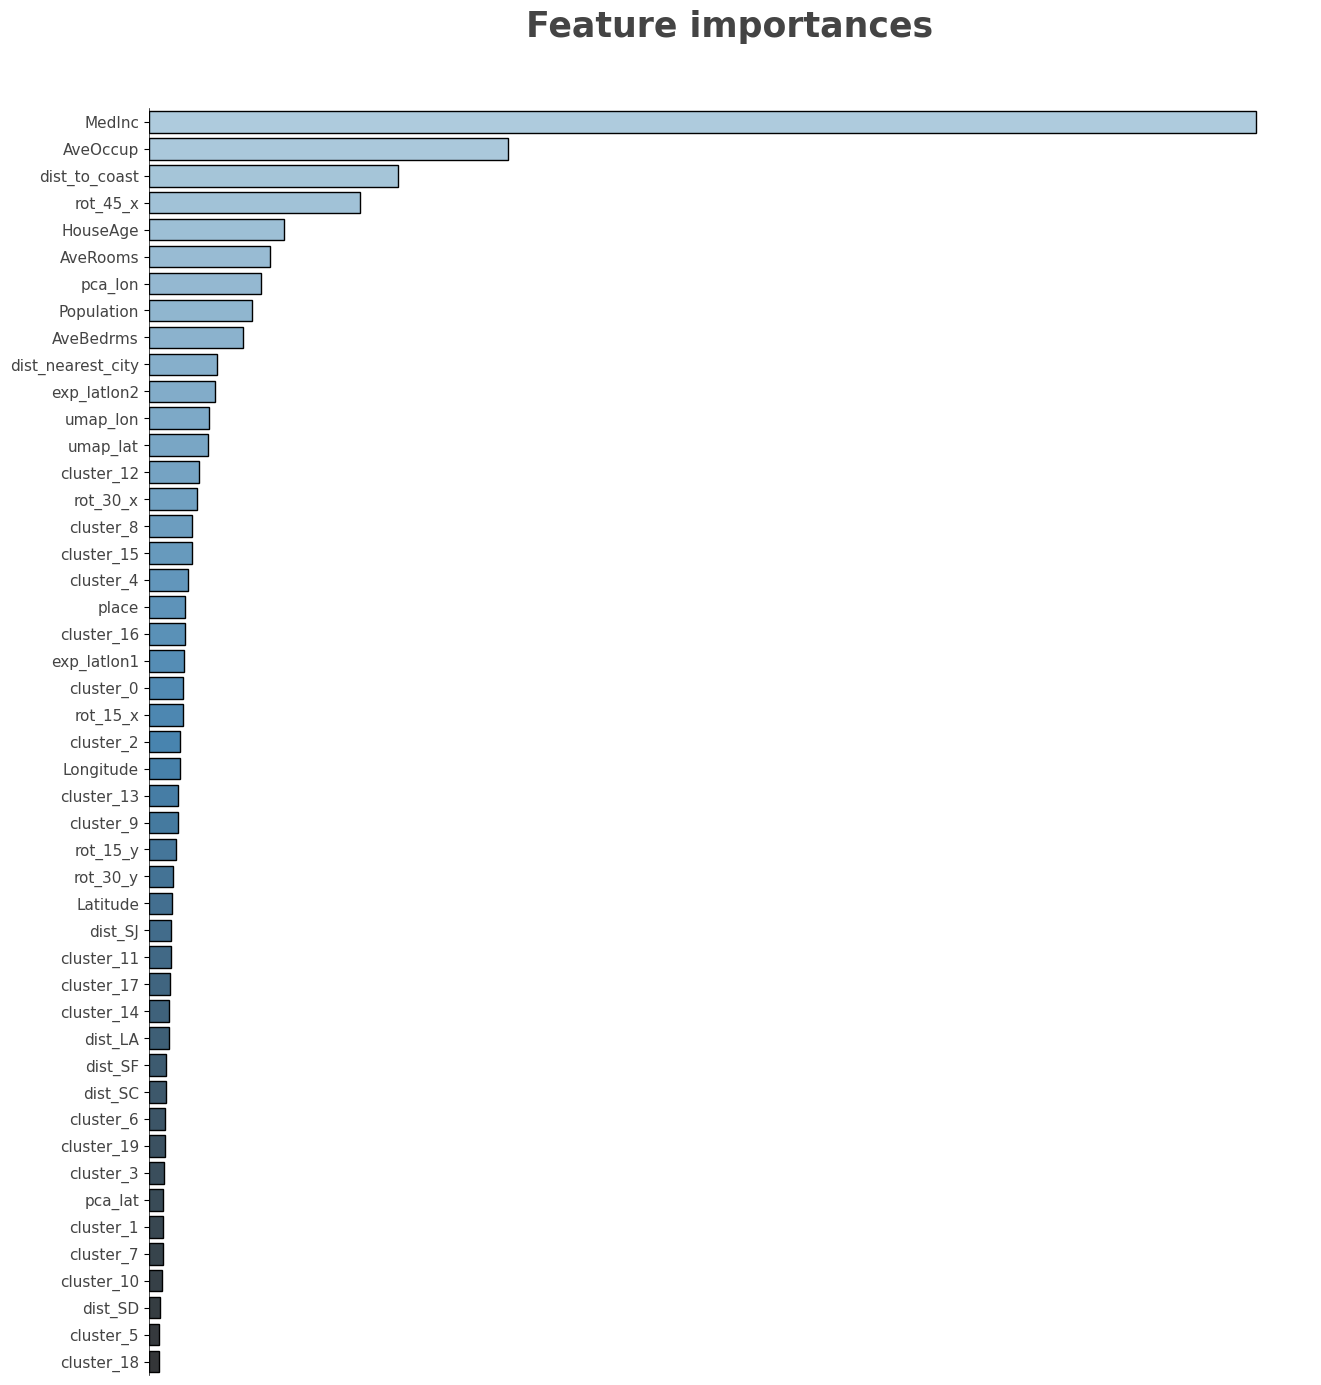

In [32]:
f_imp = pd.DataFrame({'feature': X.columns})
predictions, scores = np.zeros(len(test)), []

k = KFold(n_splits=FOLDS, random_state=42, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(k.split(X, y)):
    print(f'\n--- FOLD {fold+1} ---')

    cb_train = cb.Pool(data=X.iloc[train_idx],
                       label=y.iloc[train_idx],
                       cat_features=['place'])
    cb_valid = cb.Pool(data=X.iloc[val_idx],
                       label=y.iloc[val_idx],
                       cat_features=['place'])

    model = cb.train(params=cb_params,
                     dtrain=cb_train,
                     num_boost_round=50000,
                     evals=cb_valid,
                     early_stopping_rounds=777,
                     verbose=3000)

    f_imp['fold_'+str(fold+1)] = model.get_feature_importance()
    b_itr = model.get_best_iteration()

    val_preds = model.predict(cb_valid)
    val_score = rmse(y.iloc[val_idx], val_preds)
    scores.append(val_score)

    predictions += model.predict(test) / FOLDS
    print(f'--- RMSE: {round(val_score, 6)} | best iteration: {b_itr} ---')

    del cb_train, cb_valid, val_preds, val_score, model
    gc.collect()

print('='*45)
print(f'Mean RMSE: {round(np.mean(scores), 6)}')

f_imp['avg_imp'] = f_imp[f_imp.columns[1:]].mean(axis=1)
f_imp.sort_values('avg_imp', ascending=False, inplace=True)
f_importance_plot(f_imp)

In [33]:
cb_preds = predictions.copy()

## 6. Submission
- Blending + Rounding

In [34]:
submission = pd.read_csv('sample_submission.csv')

In [35]:
# Blending
submission['MedHouseVal'] = lgbm_preds*0.6 + cb_preds*0.4
submission.head()

,id,MedHouseVal
0,37137,0.665125
1,37138,1.039743
2,37139,4.125571
3,37140,3.335504
4,37141,2.538622


In [36]:
print(train['MedHouseVal'].nunique())

3723


In [37]:
# Rounding
vals = train['MedHouseVal'].unique().tolist()
submission['MedHouseVal'] = submission['MedHouseVal'].apply(lambda x: min(vals, key=lambda v: abs(v - x)))
submission.head()

,id,MedHouseVal
0,37137,0.665
1,37138,1.040
2,37139,4.126
3,37140,3.336
4,37141,2.539


In [38]:
submission.to_csv('submission.csv', index=False)